# <center>**PROYECTO FINAL INTERCONNECT (1er parte)**</center>

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### PASO 1 ANALISIS EXPLORATORIO DE DATOS (EDA) Y PLAN DE TRABAJO.

In [3]:
# Importación de librerias para EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [4]:
# Asignacion de datraframes

contract = pd.read_csv(r'datasets\contract.csv')
personal = pd.read_csv(r'datasets\personal.csv')
internet = pd.read_csv(r'datasets\internet.csv')
phone = pd.read_csv(r'datasets\phone.csv')

In [5]:
# Combinacion de dataframes, debido a que la informacion viene compartida entre varios sets.
df_intercon = contract.merge(personal, on='customerID', how='left').merge(
    internet, on='customerID', how='left').merge(phone, on='customerID', how='left')

print(df_intercon.columns)

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')


In [6]:
# Los nombres de columnas son confusos y no vienen estandarizados, asi que hay que modificarlos

new_columns = {'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date', 'Type': 'type', 'PaperlessBilling': 'paperless_billing',
               'PaymentMethod': 'payment_method', 'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges',
               'SeniorCitizen': 'senior_citizen', 'Partner': 'partner', 'Dependents': 'dependents', 'InternetService': 'internet_service',
               'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup', 'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support',
               'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies', 'MultipleLines': 'multiple_lines'}

df_intercon.rename(columns=new_columns, inplace=True)
print(df_intercon.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')


In [7]:
"""Para fines exploratorios y de entrenamiento de los futuros modelos, se creará la columna objetivo: 'churn' con valores booleanos,
0 para clientes que no han abandonado el servicio y 1 para los que se fueron"""

df_intercon['churn'] = df_intercon['end_date'].apply(
    lambda x:  0 if x == 'No' else 1)

In [8]:
# Revision inicial de datos
print(df_intercon.info())
print(df_intercon['churn'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [9]:
# Verificación de lista por si hay clientes duplicados

print('duplicados:', df_intercon['customer_id'].duplicated().sum())

# Porcentajes de faltantes:
total_rows = df_intercon.shape[0]
null_count = df_intercon.isnull().sum()
null_values = (null_count/total_rows) * 100

print("Porcentaje de valores faltantes en cada columna:")

print(null_values)

duplicados: 0
Porcentaje de valores faltantes en cada columna:
customer_id           0.000000
begin_date            0.000000
end_date              0.000000
type                  0.000000
paperless_billing     0.000000
payment_method        0.000000
monthly_charges       0.000000
total_charges         0.000000
gender                0.000000
senior_citizen        0.000000
partner               0.000000
dependents            0.000000
internet_service     21.666903
online_security      21.666903
online_backup        21.666903
device_protection    21.666903
tech_support         21.666903
streaming_tv         21.666903
streaming_movies     21.666903
multiple_lines        9.683374
churn                 0.000000
dtype: float64


In [10]:
# Como no hay duplicados, se rellenaran las columnas de datos vacios con la técnica simpleimputer de sklearn.

categorical_columns = ['internet_service', 'online_security',
                       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
                       'streaming_movies', 'multiple_lines']

imputer = SimpleImputer(strategy='most_frequent')

for i in categorical_columns:
    df_intercon[i] = imputer.fit_transform(df_intercon[[i]]).ravel()

print(df_intercon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

In [11]:
# Ahora que seguimos con tipo, vemos que total_charges es tipo object, hay que cambiarla a numeric.
df_intercon['total_charges'] = df_intercon['total_charges'].replace(
    ' ', np.nan)

# Convertir a numérico
df_intercon['total_charges'] = pd.to_numeric(df_intercon['total_charges'])

imputer = IterativeImputer(max_iter=10, random_state=42)
df_intercon[['total_charges']] = imputer.fit_transform(
    df_intercon[['total_charges']])


print(df_intercon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

In [12]:
# Eliminar las columnas originales 'end_date'
df_intercon.drop(columns=['end_date', 'begin_date'], inplace=True)

# Verificar las columnas del DataFrame
print(df_intercon.columns)

Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'churn'],
      dtype='object')


In [13]:
# Creacion y exportacion de df_intercon con los datos limpios a df_final

df_intercon.to_csv(r'datasets\df_intercon.csv', index=False)

### Resumen de la limpieza de datos

Los siguientes cambios fueron realizados en los datasets otorgados para el proyecto de interconnect:
1. Combinacion de DataFrames
     * Debido a que la información estaba dividida en varios datasets, el primer paso fue usar una combinación con unión izquierda por la columna de user_id para mantener todos los registros del DataFrame 'contract'
2. Renombre de columnas
     * Las columnas que venian por default tenian nombres sin formato y con mayúsculas y minusculas. Se procesaron para estandarizarlas.
3. Creación de columna objetivo
     * Debido a que la columna end_date sería la cual nos otorgaría nuestro objetivo de obtener los clientes que dejaron el servicio, se procedió a la creación de una nueva llamada 'churn' cuyos parametros boleanos serian 0 para los que no han dejado el servicio y 1 para los que si. 
4. Relleno de valores ausentes:
     * Al combinar los df, quedaron varios valores NaN por lo que el siguiente paso fue relleno de columnas categoricas, siendo estas las unicas que quedaron ausentes.
5. Conversión de tipo de dato
     * Al eliminar posibles causas del porque el pago mensual no aparecio como  objeto, se cambió su tipo a flotante.


## Visualización

### Distribución de variables numéricas.

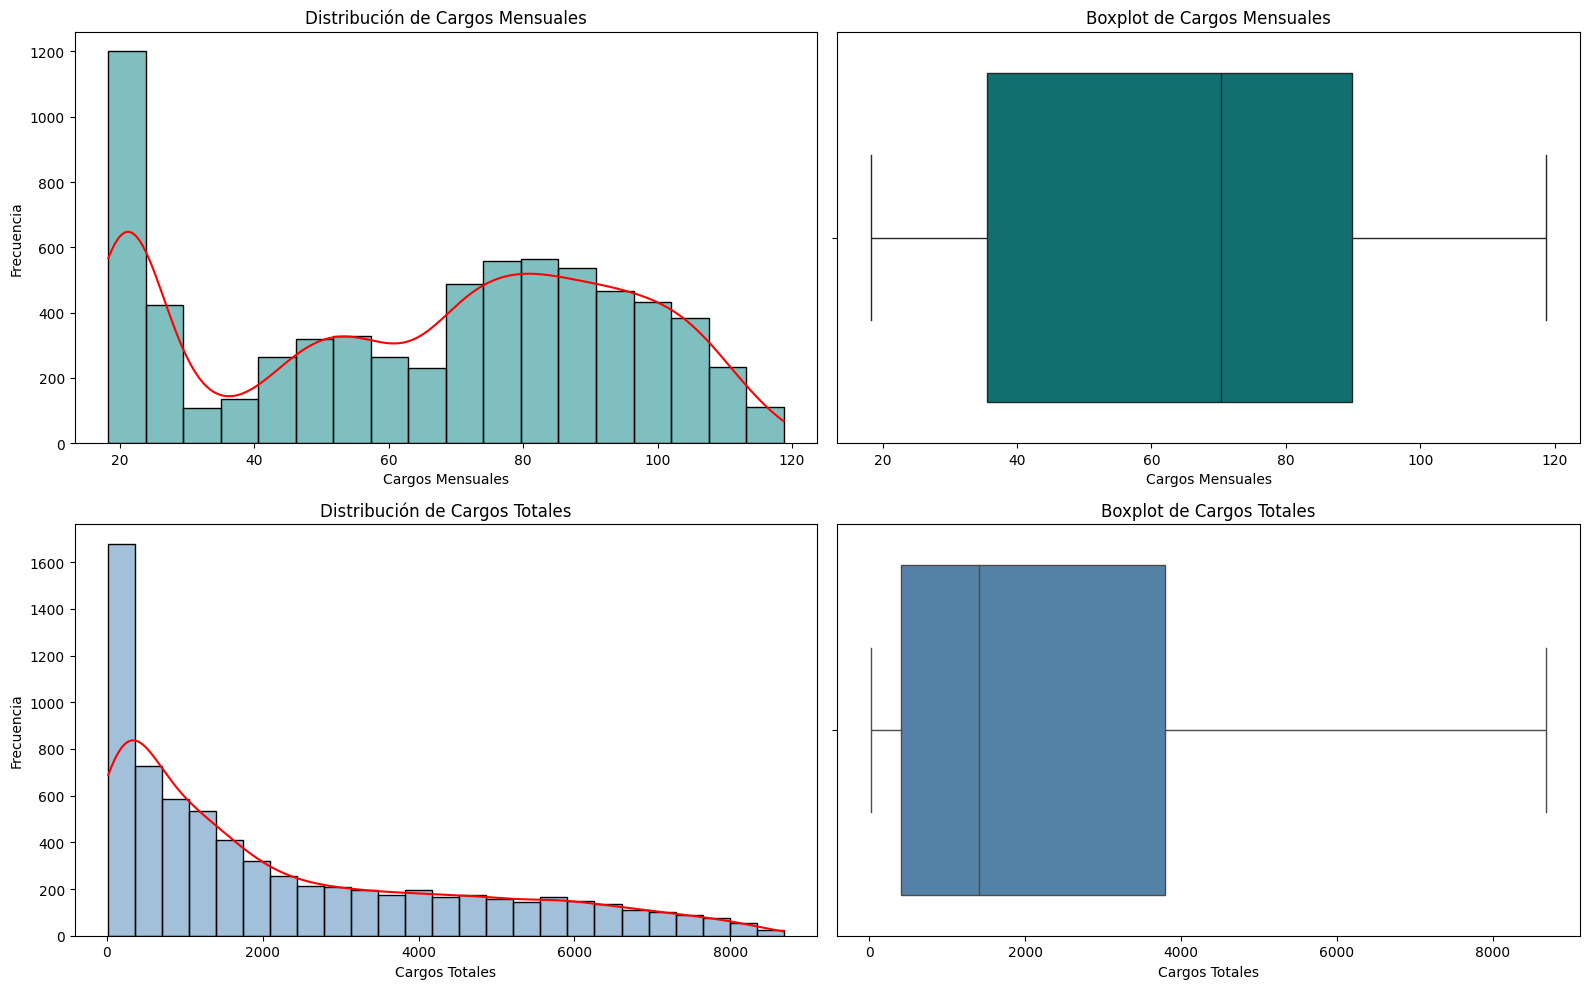

In [14]:


fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Histograma para monthly_charges
ax = axs[0, 0]
sns.histplot(df_intercon['monthly_charges'], kde=True, ax=ax, color='teal')
ax.lines[0].set_color('red')
ax.set_title('Distribución de Cargos Mensuales')
ax.set_xlabel('Cargos Mensuales')
ax.set_ylabel('Frecuencia')

# Boxplot para monthly_charges
ax = axs[0, 1]
sns.boxplot(x=df_intercon['monthly_charges'], ax=ax, color='teal')
ax.set_title('Boxplot de Cargos Mensuales')
ax.set_xlabel('Cargos Mensuales')

# Histograma para total_charges
ax = axs[1, 0]
sns.histplot(df_intercon['total_charges'], kde=True, ax=ax, color='steelblue')
ax.lines[0].set_color('red')
ax.set_title('Distribución de Cargos Totales')
ax.set_xlabel('Cargos Totales')
ax.set_ylabel('Frecuencia')

# Boxplot para total_charges
ax = axs[1, 1]
sns.boxplot(x=df_intercon['total_charges'], ax=ax, color='steelblue')
ax.set_title('Boxplot de Cargos Totales')
ax.set_xlabel('Cargos Totales')

fig.tight_layout()
plt.show()

### Distribución de la columna 'churn'

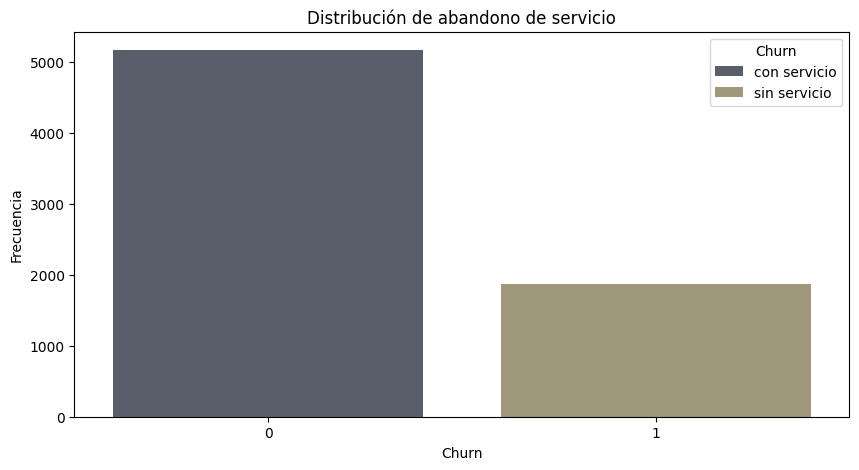

In [15]:
# Gráfico de barras para churn

palette = sns.color_palette('cividis', 2)

plt.figure(figsize=(10, 5))
sns.countplot(x='churn', data=df_intercon, hue='churn', palette=palette)
plt.title('Distribución de abandono de servicio')
plt.xlabel('Churn')
plt.ylabel('Frecuencia')
plt.legend(['con servicio', 'sin servicio'], title='Churn', loc='upper right')
plt.show()

### Relación entre variables numéricas y churn

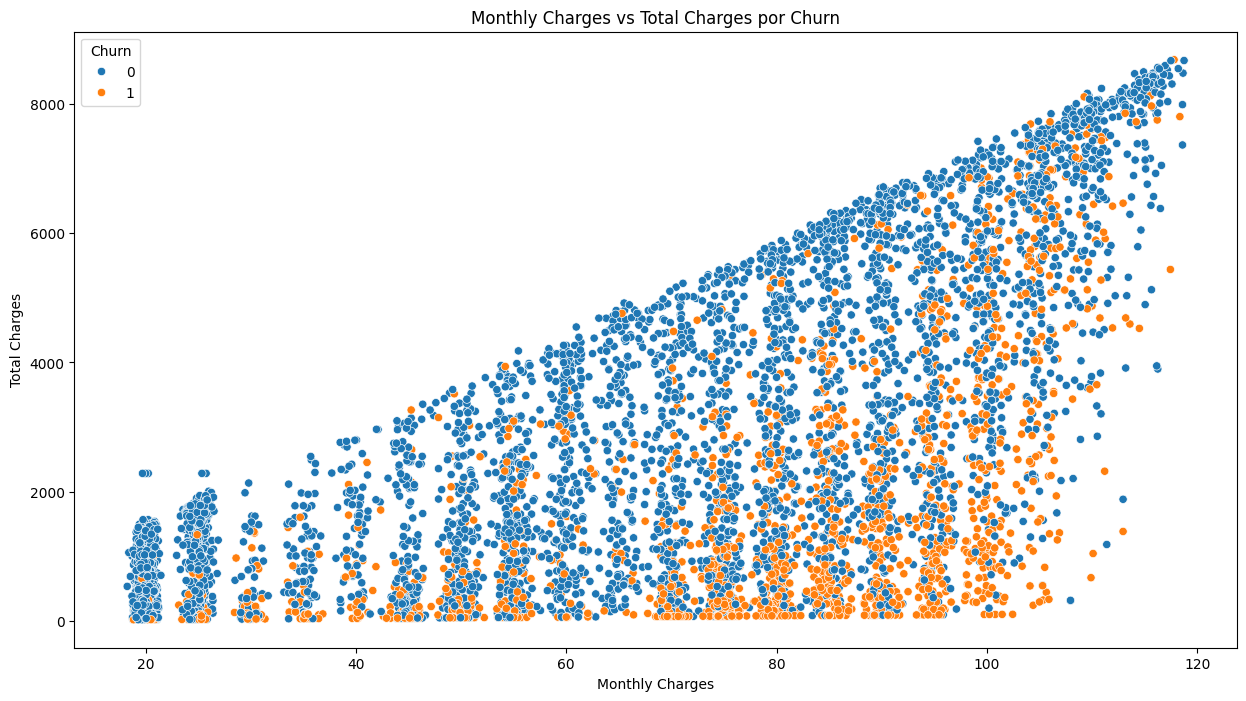

In [16]:
# Scatterplot para monthly_charges y churn
plt.figure(figsize=(15, 8))
sns.scatterplot(x=df_intercon['monthly_charges'],
                y=df_intercon['total_charges'], hue=df_intercon['churn'])
plt.title('Monthly Charges vs Total Charges por Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.legend(title='Churn')
plt.show()

### Observación de las visualizaciones.
* Distribución de Variables Numéricas:
En la distribución de las variables numéricas, observamos que la mayoría de los clientes optan por planes más económicos, como era de esperarse. Los diagramas de caja muestran que no hay datos extremos significativos, indicando que las tarifas de servicio y los cargos totales están distribuidos de manera razonable sin valores atípicos.

* Análisis de Churn:
El análisis de la tasa de abandono (churn) revela que aproximadamente una tercera parte de los clientes han abandonado el servicio. Este hallazgo sugiere que, al desarrollar el modelo predictivo, es crucial considerar técnicas de balanceo de datos, como el sobremuestreo de la clase minoritaria (clientes que no han abandonado), para evitar un sesgo hacia la clase mayoritaria y mejorar la precisión del modelo.

* Relación entre Variables Numéricas y Churn:
Al examinar la relación entre las variables numéricas y la tasa de abandono, observamos que la mayoría de los clientes que abandonaron el servicio tenían contratos de mediano plazo y varios servicios contratados. Estos clientes tienen cargos mensuales que varían entre 70 y 100, con cargos totales que oscilan entre 1000 y 2000 unidades. Este patrón sugiere que los clientes con pagos más altos y contratos a mediano plazo son más propensos a abandonar el servicio, lo cual es una información valiosa para diseñar estrategias de retención de clientes.


## Plan de trabajo

1. Definición del problema y preparación de datos: Definición de objetivo y limpieza de datos.
2. Análisis exploratorio de datos (EDA)
3. Preprocesamiento de datos: 
    * Conversión de variables categóricas en dummies 
    * manejo de desequilibrio de clases 
    * Selección de características: Aplicación de técnicas de filtrado y envoltura para reducir la dimensionalidad y seleccionar características relevantes.
4. Selección y entrenamiento de modelos: division de sets para entrenamiento y prueba, probar algoritmos de clasificación.
5. Evaluación y optimización del modelo: Evaluación de los modelos con metricas apropiadas, optimización de hiperparámetros y selección del modelo
